##Import Library

In [ ]:
!pip install geoplot

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stat
import collections
import geopandas as gpd
import geoplot as gplt
from shapely.wkt import loads
from sklearn.preprocessing import MultiLabelBinarizer, QuantileTransformer 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Embedding
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

##Import Data
To begin width, let's import our data, and take a look them.
Let's specify the fields we have
* **show_id** - 
* **type** - 
* **title** - 
* **director** - 
* **cast** - 
* **country** - 
* **date_added** - 
* **release_year** - 
* **rating** - 
* **duration** - 
* **listed_in** - 
* **description** - 


In [ ]:
df_netflix_raw = pd.read_csv('/content/drive/MyDrive/Education/Data Science & Math/Projects/data/Netflix/netflix_titles.csv')
df_netflix = df_netflix_raw.copy()

In [ ]:
df_netflix_raw.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [ ]:
df_netflix.shape

(7787, 12)

## Data Cleaning

In [ ]:
df_netflix.isna().sum()

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

###Director

In [ ]:
unique_genres = []
for genres in df_netflix['listed_in']:
    genres = genres.split(', ')
    for genre in genres:
        if genre not in unique_genres:
            unique_genres.append(genre)

In [ ]:
genres_counts = pd.DataFrame({genre: [0,0] for genre in unique_genres}, index=['director', 'nan director'])
for genres in df_netflix[df_netflix.director.isna() == False]['listed_in']:
    genres = genres.split(', ')
    for genre in genres:
        genres_counts[genre]['director'] += 1

for genres in df_netflix[df_netflix.director.isna() == True]['listed_in']:
    genres = genres.split(', ')
    for genre in genres:
        genres_counts[genre]['nan director'] += 1

In [ ]:
genres_counts

,International TV Shows,TV Dramas,TV Sci-Fi & Fantasy,Dramas,International Movies,Horror Movies,Action & Adventure,Independent Movies,Sci-Fi & Fantasy,TV Mysteries,Thrillers,Crime TV Shows,Docuseries,Documentaries,Sports Movies,Comedies,Anime Series,Reality TV,TV Comedies,Romantic Movies,Romantic TV Shows,Science & Nature TV,Movies,British TV Shows,Korean TV Shows,Music & Musicals,LGBTQ Movies,Faith & Spirituality,Kids' TV,TV Action & Adventure,Spanish-Language TV Shows,Children & Family Movies,TV Shows,Classic Movies,Cult Movies,TV Horror,Stand-Up Comedy & Talk Shows,Teen TV Shows,Stand-Up Comedy,Anime Features,TV Thrillers,Classic & Cult TV
director,99,52,4,2085,2395,310,714,669,215,9,488,51,46,739,190,1447,9,5,31,520,20,3,36,23,9,308,86,57,18,11,13,500,8,102,59,6,11,3,304,57,3,3
nan director,1100,652,72,21,42,2,7,4,3,81,3,376,307,47,6,24,139,217,494,11,313,82,20,209,141,13,4,0,396,139,134,32,4,1,0,63,41,57,25,0,47,24


In [ ]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stat.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [ ]:
cramers_corrected_stat(genres_counts.T)

0.9071235720478048

In [ ]:
genres_counts = pd.DataFrame({genre: [0,0] for genre in unique_genres}, index=['cast', 'nan cast'])
for genres in df_netflix[df_netflix.cast.isna() == False]['listed_in']:
    genres = genres.split(', ')
    for genre in genres:
        genres_counts[genre]['cast'] += 1

for genres in df_netflix[df_netflix.cast.isna() == True]['listed_in']:
    genres = genres.split(', ')
    for genre in genres:
        genres_counts[genre]['nan cast'] += 1

In [ ]:
cramers_corrected_stat(genres_counts.T)

0.4636939876368608

###Date added

In [ ]:
df_netflix = df_netflix[df_netflix['date_added'].notna()]

###Certification

In [ ]:
df_netflix.rating.unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y', nan,
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [ ]:
rating_replacements = {
    67: 'TV-PG',
    2359: 'PG-13',
    3660: 'PG',
    3736: 'TV-MA',
    3737: 'TV-MA',
    3738: 'TV-MA',
    4323: 'PG-13',
}

for id, rate in rating_replacements.items():
    df_netflix.loc[id, 'rating'] = rate

In [ ]:
df_netflix['rating'].isna().sum()

0

In [ ]:
categories = ", ".join(df_netflix.country.fillna('none')).split(",")
counter_list = collections.Counter(categories).most_common(20)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


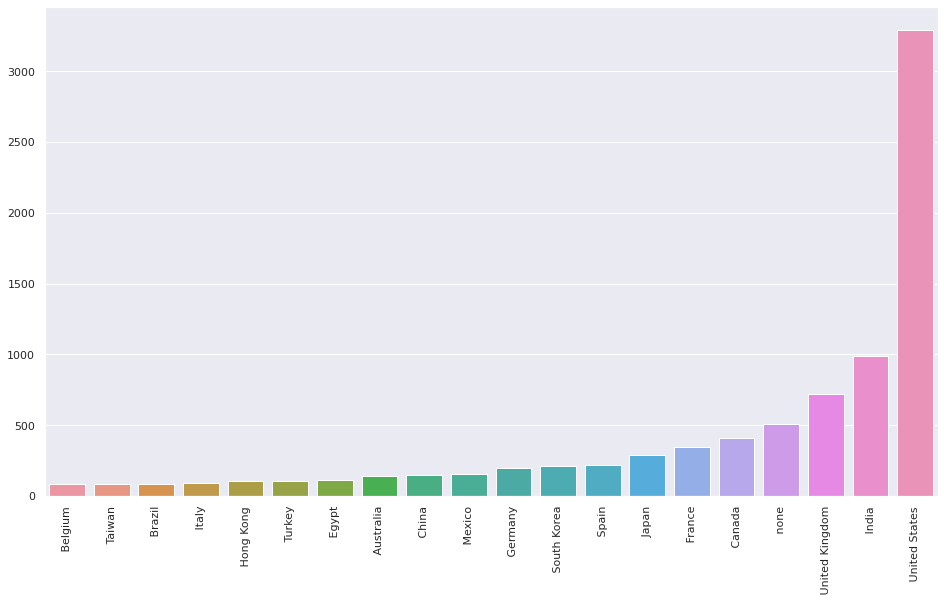

In [ ]:
labels = [i[0] for i in counter_list][::-1]
values = [i[1] for i in counter_list][::-1]
plt.figure(figsize=(16,9))
chart = sns.barplot(labels, values)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.show()

In [ ]:
df_netflix.loc[df_netflix.country.isna() == True, 'country'] = df_netflix['country'].mode()[0]

In [ ]:
df_netflix['country'] = df_netflix['country'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

In [ ]:
df_netflix.loc[df_netflix.director.isna() == True, 'director'] = "No Director"
df_netflix.loc[df_netflix.cast.isna() == True, 'cast'] = "No Cast"

In [ ]:
df_netflix.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

###Duplicates

In [ ]:
before_remove = df_netflix.shape[0]
df_netflix = df_netflix.drop_duplicates("title")
after_remove = df_netflix.shape[0]
before_remove - after_remove

0

##Data Analysis

###Base Analysis

In [ ]:
df_netflix['main_country'] = df_netflix['country'].apply(lambda x: x[0])

In [ ]:
categories = ", ".join(df_netflix['listed_in']).split(", ")
counter_list = collections.Counter(categories).most_common(50)

movie_rows = df_netflix.loc[df_netflix["type"] == "Movie"]
tv_rows = df_netflix.loc[df_netflix["type"] == "TV Show"]

categories_labels = [i[0] for i in counter_list][::-1]
categories_values = [i[1] for i in counter_list][::-1]

releases = df_netflix['release_year'].value_counts()
releases_movie = movie_rows['release_year'].value_counts()
releases_tv = movie_rows['release_year'].value_counts()

# Extract world's geoposition
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = world[['geometry', 'name']]
countries = countries.rename(columns={'name':'country'})
# Create a DataFrame with amount of records per country
gpd_count = pd.DataFrame(df_netflix['main_country'].value_counts())
gpd_count = gpd_count.rename(columns={'main_country': 'count'})
# Retrieve top 50 countries
gpd_count = gpd_count.sort_values('count', ascending=False)[:50]
# Exclude redundant (they don't appear in the 'countries'-dataset) countries and rename USA
gpd_count = gpd_count.rename(index={'United States':'United States of America'})
gpd_count = gpd_count.drop(['Hong Kong', 'Singapore'])
if 'Czech Republic' in  gpd_count.index:
    gpd_count = gpd_count.drop('Czech Republic')
# Get appropriate geopositions for the required countries
geom = []
for country in gpd_count.index:
    country_geom = countries[countries['country'] == country]['geometry']
    geom.append(country_geom[country_geom.index[0]])
# Add them up to the dataframe. And create GeoDataFrame to accurate plot.
gpd_count['geometry'] = geom
gpd_count = gpd.GeoDataFrame(gpd_count, geometry='geometry')

casts = ", ".join(df_netflix.copy()['cast']).split(", ")
counter_list = collections.Counter(casts).most_common(5)
most_common__movie_actors = [i for i in counter_list if i[0] != "No Cast"]
top5_movie_act = [i[0] for i in most_common__movie_actors][::-1]
top5_movie_act_count = [i[1] for i in most_common__movie_actors][::-1]
top5_movie_dir = df_netflix[df_netflix['type'] == 'Movie'].director.value_counts().head(6).sort_values(ascending=True).drop('No Director')

certification = df_netflix['rating'].value_counts()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


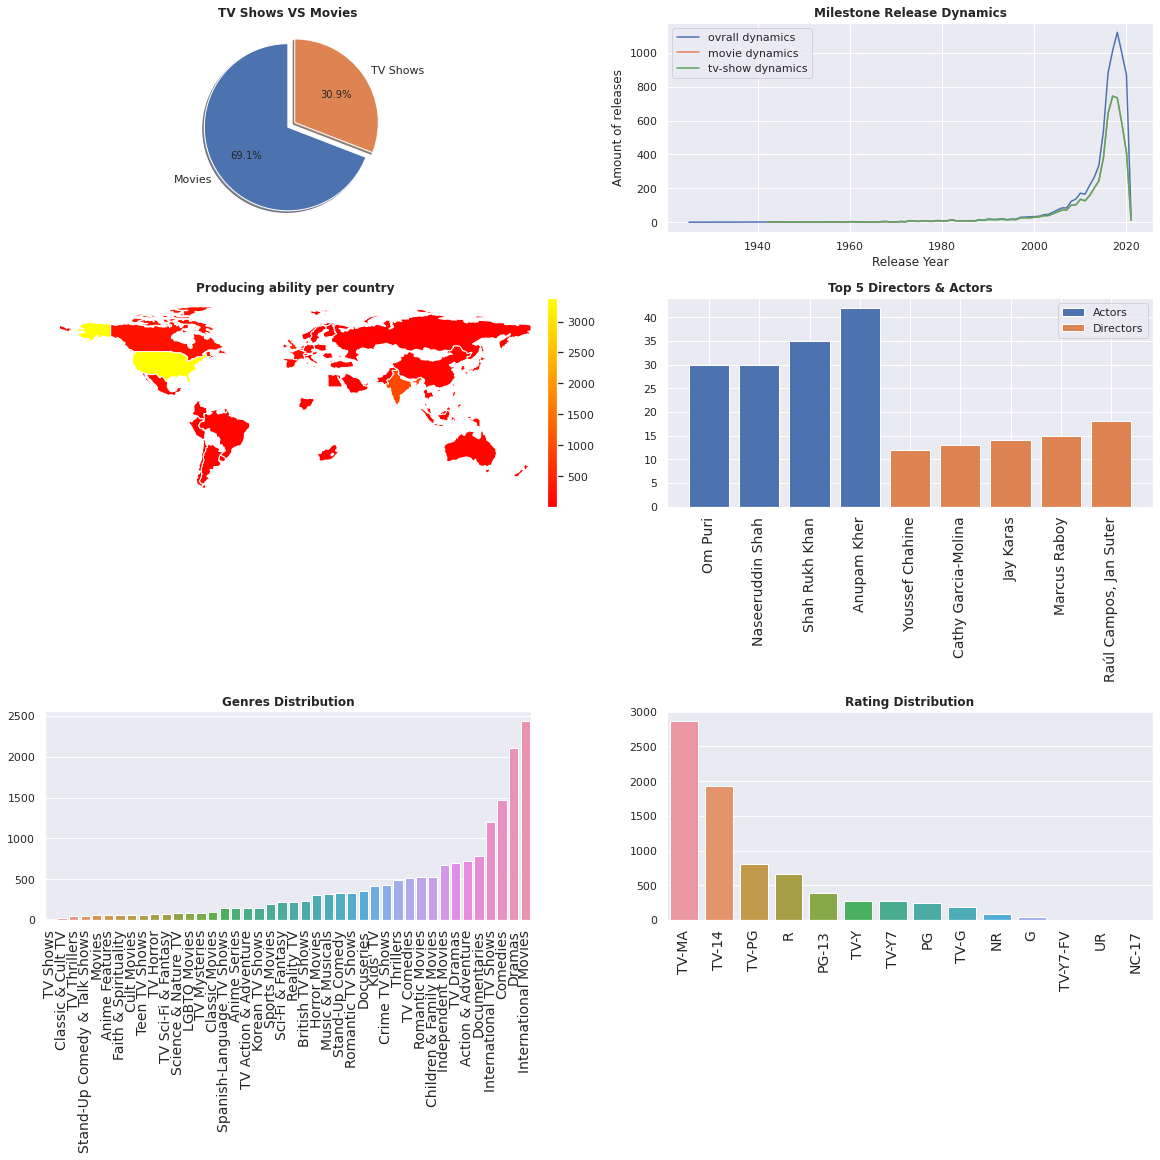

In [ ]:
fig = plt.figure(figsize=(16,16), constrained_layout=True)
gs = fig.add_gridspec(3, 2)

# TV Shows vs Movies
f_ax1 = fig.add_subplot(gs[0,0]) 
# Milestone Release Dynamics
f_ax2 = fig.add_subplot(gs[0,1])
# Producing ability per country
f_ax3 = fig.add_subplot(gs[1,0])

f_ax4 = fig.add_subplot(gs[1,1])
# Genres Distribution
f_ax5 = fig.add_subplot(gs[2, 0]) 
f_ax6 = fig.add_subplot(gs[2, 1]) 
 

f_ax1.pie([movie_rows.shape[0]/df_netflix.shape[0], tv_rows.shape[0]/df_netflix.shape[0]],explode=(0, 0.1,), labels=["Movies", "TV Shows"], autopct='%1.1f%%',
        shadow=True, startangle=90)
f_ax1.set_title('TV Shows VS Movies', fontweight='bold')

sns.lineplot(x=releases.index, y=releases.values, ax=f_ax2)
sns.lineplot(x=releases_movie.index, y=releases_movie.values, ax=f_ax2)
sns.lineplot(x=releases_tv.index, y=releases_tv.values, ax=f_ax2)

f_ax2.set_xlabel("Release Year", size=12)
f_ax2.set_ylabel("Amount of releases", size=12)
f_ax2.grid(True)
f_ax2.set_title('Milestone Release Dynamics', fontweight='bold')
f_ax2.legend(['ovrall dynamics', 'movie dynamics', 'tv-show dynamics'])

gplt.choropleth(gpd_count, ax=f_ax3, hue='count', cmap='autumn', legend=True)
f_ax3.set_title('Producing ability per country', fontweight='bold')

f_ax4.bar(top5_movie_act, top5_movie_act_count, label='Actors')
f_ax4.bar(top5_movie_dir.index, top5_movie_dir.values, label='Directors')
f_ax4.set_xticklabels(top5_movie_act + list(top5_movie_dir.index), rotation=90, fontsize=14)
f_ax4.grid(True, axis='y')
f_ax4.legend()
f_ax4.set_title('Top 5 Directors & Actors', fontweight='bold')


# Genre Dist
sns.barplot(categories_labels, categories_values, ax=f_ax5)
f_ax5.set_xticklabels(f_ax5.get_xticklabels(), rotation=90, fontsize=14)
f_ax5.grid(True, axis='y')
f_ax5.set_title('Genres Distribution', fontweight='bold')

sns.barplot(certification.index, certification.values, ax=f_ax6)
f_ax6.set_xticklabels(f_ax6.get_xticklabels(), rotation=90, fontsize=14)
f_ax6.grid(True, axis='y')
f_ax6.set_title('Rating Distribution', fontweight='bold')

plt.show()

###Age Group

In [ ]:
ratings_ages = {
    'TV-PG': 'Pre-teens',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Pre-teens',
    'TV-Y7': 'Pre-teens',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Pre-teens',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}
df_netflix['age_group'] = df_netflix['rating'].replace(ratings_ages)
df_netflix['age_group'].unique()

array(['Adults', 'Teens', 'Pre-teens', 'Kids'], dtype=object)

Text(0.5, 1.0, "Content's age group")

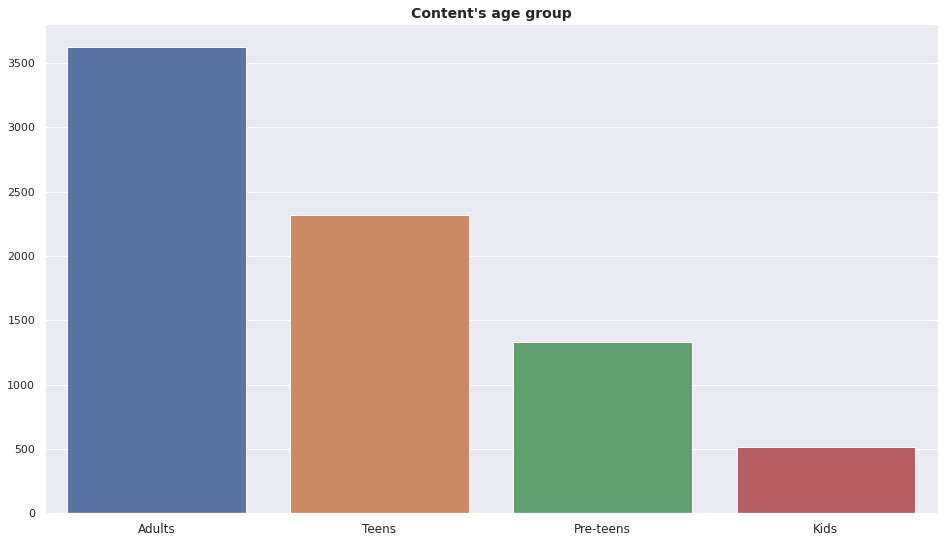

In [ ]:
age_groups = df_netflix['age_group'].value_counts()
plt.figure(figsize=(16,9))
chart = sns.barplot(x=age_groups.index, y=age_groups.values)
plt.xticks(np.arange(0, len(chart.get_xticklabels()), 1), labels = chart.get_xticklabels(), fontsize=12 )
plt.title("Content's age group", fontsize=14, fontweight='bold')

In [ ]:
df_netflix = df_netflix.drop('rating', axis=1)

In [ ]:
df_netflix['age_group'] = pd.Categorical(df_netflix['age_group'], categories=['Adults', 'Teens', 'Pre-teens', 'Kids'])

##Date

In [ ]:
df_netflix['year_added'] = df_netflix['date_added'].apply(lambda x: x.split(" ")[-1])
df_netflix['day_added'] = df_netflix['date_added'].apply(lambda x: x.split(" ")[-2][:-1])
df_netflix['month_added'] = df_netflix['date_added'].apply(lambda x: x.split(" ")[-3])
df_netflix = df_netflix.drop('date_added', axis=1)

In [ ]:
def quarter_of(month):
    if month == 'January' or month == 'February' or month == 'March':
       return 'Q1'
    elif month == 'April' or month == 'April' or month == 'June':
       return 'Q2'
    elif month == 'July' or month == 'August' or month == 'September':
       return 'Q3'
    else:
       return 'Q4'
    
    
df_netflix['quarter_added'] = df_netflix['month_added'].apply(lambda x: quarter_of(x))

In [ ]:
df_netflix['year_added'] = pd.to_numeric(df_netflix['year_added'])
df_netflix['release_year'] = pd.to_numeric(df_netflix['release_year'])
df_netflix['day_added'] = pd.to_numeric(df_netflix['day_added'])

Text(0.5, 1.0, 'Quarter replenishment')

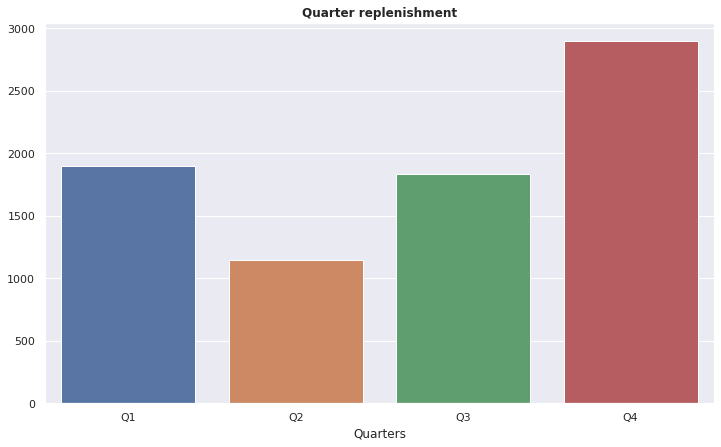

In [ ]:
quarters = df_netflix['quarter_added'].value_counts()
quarters = quarters.sort_index()
plt.figure(figsize=(12,7))
sns.barplot(x=quarters.index, y=quarters.values)
plt.xlabel('Quarters')
plt.title('Quarter replenishment', fontweight='bold')

In [ ]:
grouped = pd.DataFrame(df_netflix.groupby(by=['year_added','quarter_added'])['quarter_added'].count())
grouped.columns = ['count']
grouped = grouped.reset_index()
grouped.iloc[grouped.groupby('year_added').idxmin()['count']]#idxmax

,year_added,quarter_added,count
0,2008,Q1,2
1,2009,Q4,2
2,2010,Q4,1
3,2011,Q3,1
5,2012,Q1,1
7,2013,Q1,1
11,2014,Q2,3
14,2015,Q1,10
19,2016,Q2,41
23,2017,Q2,190


In [ ]:
df_q4 = df_netflix[df_netflix['quarter_added'] == 'Q4']
df_q2 = df_netflix[df_netflix['quarter_added'] == 'Q2']
categories = ", ".join(df_q4['listed_in']).split(", ")
counter_list = collections.Counter(categories).most_common(10)
df_q4_labels = [i[0] for i in counter_list][::-1]
df_q4_values = [i[1] for i in counter_list][::-1]

categories = ", ".join(df_q2['listed_in']).split(", ")
counter_list = collections.Counter(categories).most_common(10)
df_q2_labels = [i[0] for i in counter_list][::-1]
df_q2_values = [i[1] for i in counter_list][::-1]

[Text(0, 0, 'TV Comedies'),
 Text(0, 0, 'Romantic Movies'),
 Text(0, 0, 'Action & Adventure'),
 Text(0, 0, 'TV Dramas'),
 Text(0, 0, 'Independent Movies'),
 Text(0, 0, 'Documentaries'),
 Text(0, 0, 'International TV Shows'),
 Text(0, 0, 'Comedies'),
 Text(0, 0, 'Dramas'),
 Text(0, 0, 'International Movies')]

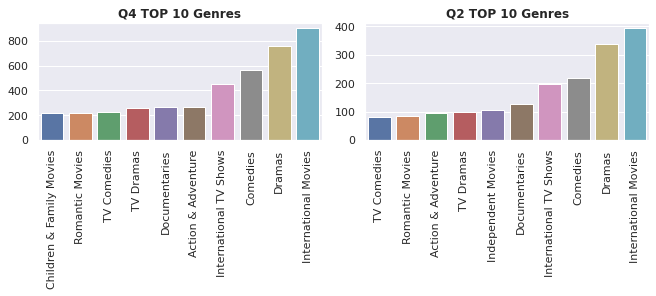

In [ ]:
fig = plt.figure(figsize=(9,4), constrained_layout=True)
gs = fig.add_gridspec(1, 2)

f_ax1 = fig.add_subplot(gs[0,0]) 

f_ax2 = fig.add_subplot(gs[0,1])

sns.barplot(x=df_q4_labels, y=df_q4_values, ax=f_ax1)
f_ax1.set_xticklabels(df_q4_labels, rotation=90)
f_ax1.set_title('Q4 TOP 10 Genres', fontweight='bold')
sns.barplot(x=df_q2_labels, y=df_q2_values, ax=f_ax2)
f_ax2.set_title('Q2 TOP 10 Genres', fontweight='bold')
f_ax2.set_xticklabels(df_q2_labels, rotation=90)

In [ ]:
df_netflix = df_netflix.drop(['quarter_added', 'day_added', 'month_added'], axis=1)

In [ ]:
accept_duration = df_netflix.loc[:, ['year_added', 'release_year']]
accept_duration['duration'] = accept_duration['year_added'] - accept_duration['release_year']
accept_duration = accept_duration.drop(accept_duration[accept_duration['duration'] < 0].index)
accept_duration = accept_duration[accept_duration['release_year'] >= 2008]

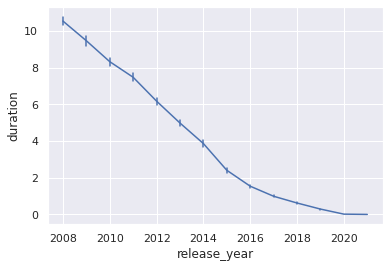

In [ ]:
sns.lineplot(data=accept_duration, x='release_year', y='duration', err_style="bars")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(1997.749377766042, 2021.0)

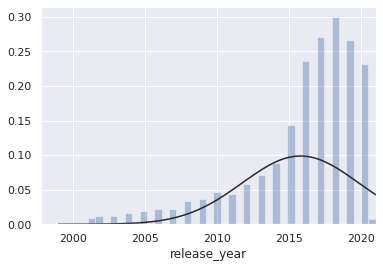

In [ ]:
sns.distplot(df_netflix.loc[df_netflix['release_year'] > 2000, 'release_year'], fit=stat.norm, kde=False)
plt.xlim(right=2021)

In [ ]:
df_netflix['genres'] = df_netflix['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
df_netflix['main_genre'] = df_netflix['genres'].apply(lambda x: x[0])
df_netflix = df_netflix.drop('listed_in', axis=1)

In [ ]:
df_tv = df_netflix[df_netflix['type'] == 'TV Show']
df_movie = df_netflix[df_netflix['type'] == 'Movie']

In [ ]:
tv_labels = df_tv['main_genre'].value_counts().index[:10]
tv_values = df_tv['main_genre'].value_counts().values[:10]
movie_labels = df_movie['main_genre'].value_counts().index[:10]
movie_values = df_movie['main_genre'].value_counts().values[:10]

Text(0.5, 1.0, 'Movie TOP 10 Gneres')

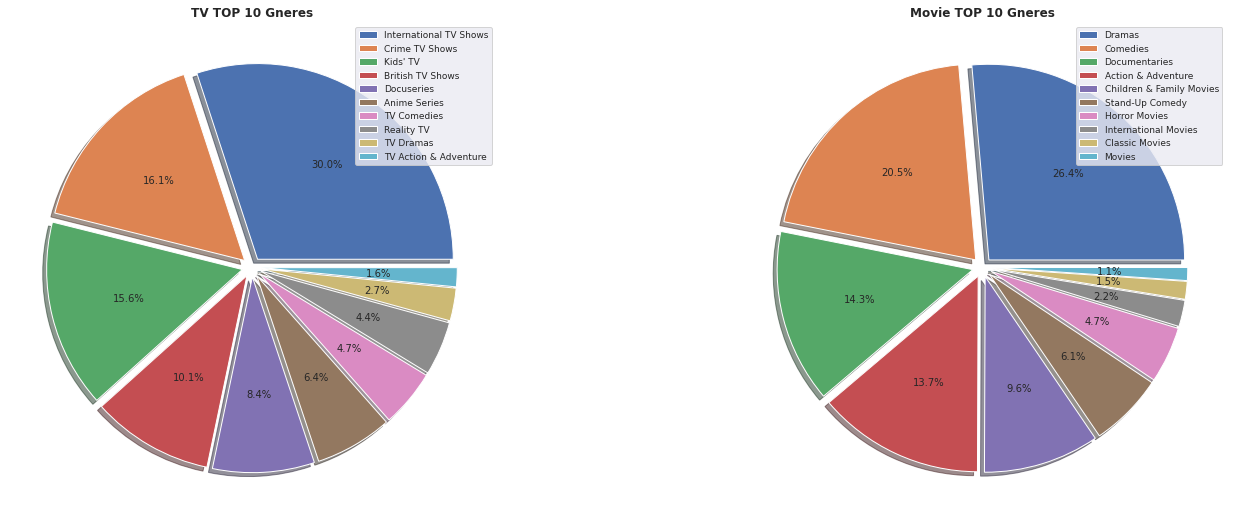

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(24,9))

axes[0].pie(tv_values, labels=tv_labels, labeldistance=None, autopct='%1.1f%%', shadow=True, explode=np.full(len(tv_values), 0.05))
axes[0].legend(prop={'size': 9})
axes[0].set_title('TV TOP 10 Gneres', fontweight='bold')
axes[1].pie(movie_values, labels=movie_labels, labeldistance=None, autopct='%1.1f%%', shadow=True, explode=np.full(len(tv_values), 0.05))
axes[1].legend(prop={'size': 9})
axes[1].set_title('Movie TOP 10 Gneres', fontweight='bold')

In [ ]:
movie_mode_genre_year = df_movie[df_movie['release_year'] >= 2000].groupby('release_year')['main_genre'].agg(lambda x: x.value_counts().index[0])
tv_mode_genre_year = df_tv[df_tv['release_year'] >= 2000].groupby('release_year')['main_genre'].agg(lambda x: x.value_counts().index[0])

In [ ]:
tv_mode_genre_year

release_year
2000              Anime Series
2001          British TV Shows
2002    International TV Shows
2003    International TV Shows
2004    International TV Shows
2005    International TV Shows
2006              Anime Series
2007                  Kids' TV
2008              Anime Series
2009    International TV Shows
2010    International TV Shows
2011    International TV Shows
2012    International TV Shows
2013    International TV Shows
2014    International TV Shows
2015    International TV Shows
2016    International TV Shows
2017    International TV Shows
2018    International TV Shows
2019    International TV Shows
2020    International TV Shows
2021                  Kids' TV
Name: main_genre, dtype: object

In [ ]:
def calculate_mlb(series):
    mlb = MultiLabelBinarizer()
    mlb_df = pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)
    return mlb_df

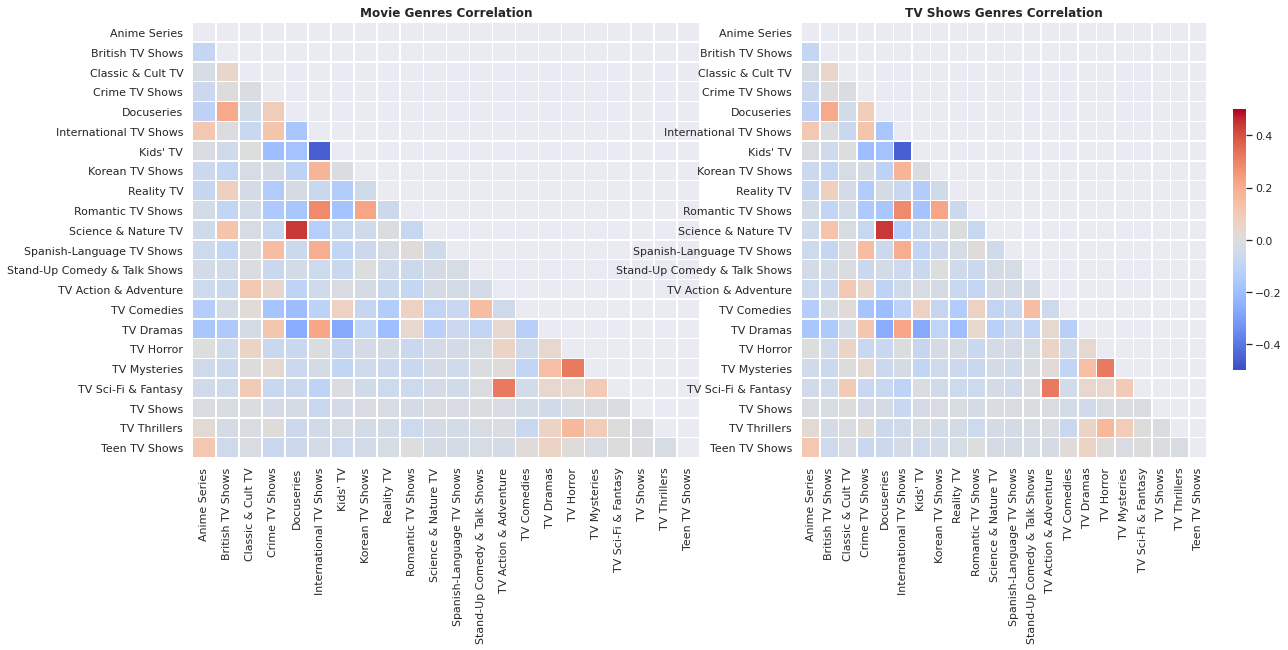

In [ ]:
genres_df = calculate_mlb(df_movie['genres'])
genres_df = calculate_mlb(df_tv['genres'])
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

movie_corr = genres_df.corr()
movie_mask = np.zeros_like(movie_corr, dtype=np.bool)
movie_mask[np.triu_indices_from(movie_mask)] = True
pl1 = sns.heatmap(movie_corr, mask=movie_mask, cbar=False, ax=axes[0], cmap="coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
axes[0].set_title('Movie Genres Correlation', fontweight='bold')

show_corr = genres_df.corr()
show_mask = np.zeros_like(show_corr, dtype=np.bool)
show_mask[np.triu_indices_from(show_mask)] = True
pl2 = sns.heatmap(show_corr, mask=show_mask, ax=axes[1], cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
axes[1].set_title('TV Shows Genres Correlation', fontweight='bold')

plt.show()

##Duration


In [ ]:
df_movie['duration_num'] = df_movie['duration'].apply(lambda x: int(x.split(' ')[0]))
def interval(min):
    if min < 90:
      return '0 - 1.5 hours'
    elif min >= 90 and min < 150:
      return '1.5 - 2.5 hours'
    else:
      return '2.5+ hours'
df_movie['duration_interval'] = df_movie['duration_num'].apply(lambda x: interval(x))
df_movie = df_movie.drop('duration_num', axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, '1.5 - 2.5 hours'),
 Text(0, 0, '0 - 1.5 hours'),
 Text(0, 0, '2.5+ hours')]

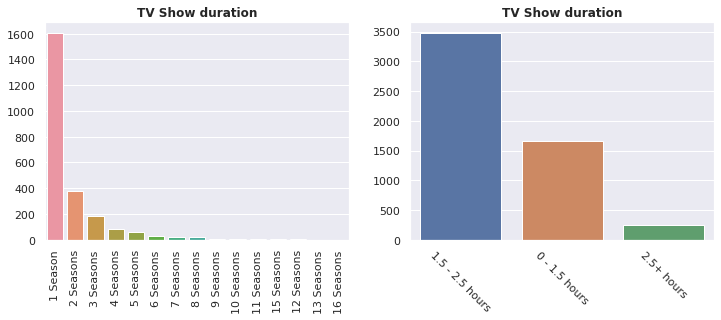

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
movie_duration = df_movie['duration_interval'].value_counts()
tv_duration = df_tv['duration'].value_counts()
sns.barplot(tv_duration.index, tv_duration.values, ax=axes[0])
axes[0].set_title('TV Show duration', fontweight='bold')
axes[0].set_xticklabels(tv_duration.index, rotation=90)
sns.barplot(movie_duration.index, movie_duration.values, ax=axes[1])
axes[1].set_title('TV Show duration', fontweight='bold')
axes[1].set_xticklabels(movie_duration.index, rotation=-45)

In [ ]:
first_interval = df_movie[df_movie['duration_interval'] == '0 - 1.5 hours']
second_interval = df_movie[df_movie['duration_interval'] == '1.5 - 2.5 hours']
third_interval = df_movie[df_movie['duration_interval'] == '2.5+ hours']

In [ ]:
top5_shortest = first_interval['main_genre'].value_counts()[:5]
top5_midterm = second_interval['main_genre'].value_counts()[:5]
top5_longest = third_interval['main_genre'].value_counts()[:5]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


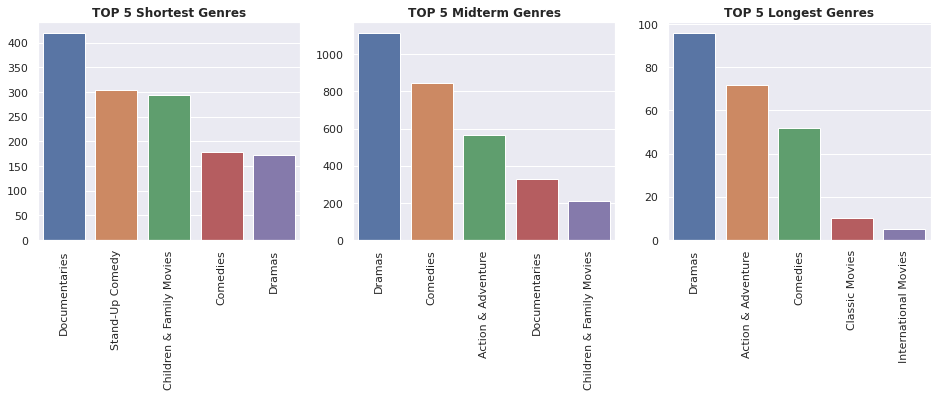

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
sns.barplot(top5_shortest.index, top5_shortest.values, ax=axes[0])
axes[0].set_title('TOP 5 Shortest Genres', fontweight='bold')
axes[0].set_xticklabels(top5_shortest.index, rotation=90)
sns.barplot(top5_midterm.index, top5_midterm.values, ax=axes[1])
axes[1].set_title('TOP 5 Midterm Genres', fontweight='bold')
axes[1].set_xticklabels(top5_midterm.index, rotation=90)
sns.barplot(top5_longest.index, top5_longest.values, ax=axes[2])
axes[2].set_title('TOP 5 Longest Genres', fontweight='bold')
axes[2].set_xticklabels(top5_longest.index, rotation=90)

plt.show()

In [ ]:
seasons_top_genres = {'1 Season':[], '2 Seasons':[], '3 Seasons':[], '4 Seasons':[]}

for i in range(4):
    season_num =  str(i + 1) + ' Season' if i == 0 else str(i + 1) + ' Seasons'
    i_season = df_tv[df_tv['duration'] == season_num]
    seasons_top_genres.update({season_num: i_season['main_genre'].value_counts()[:10]})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

[Text(0, 0, "Kids' TV"),
 Text(0, 0, 'International TV Shows'),
 Text(0, 0, 'British TV Shows'),
 Text(0, 0, 'TV Comedies'),
 Text(0, 0, 'Crime TV Shows'),
 Text(0, 0, 'TV Dramas'),
 Text(0, 0, 'Docuseries'),
 Text(0, 0, 'Anime Series'),
 Text(0, 0, 'Classic & Cult TV'),
 Text(0, 0, 'Romantic TV Shows')]

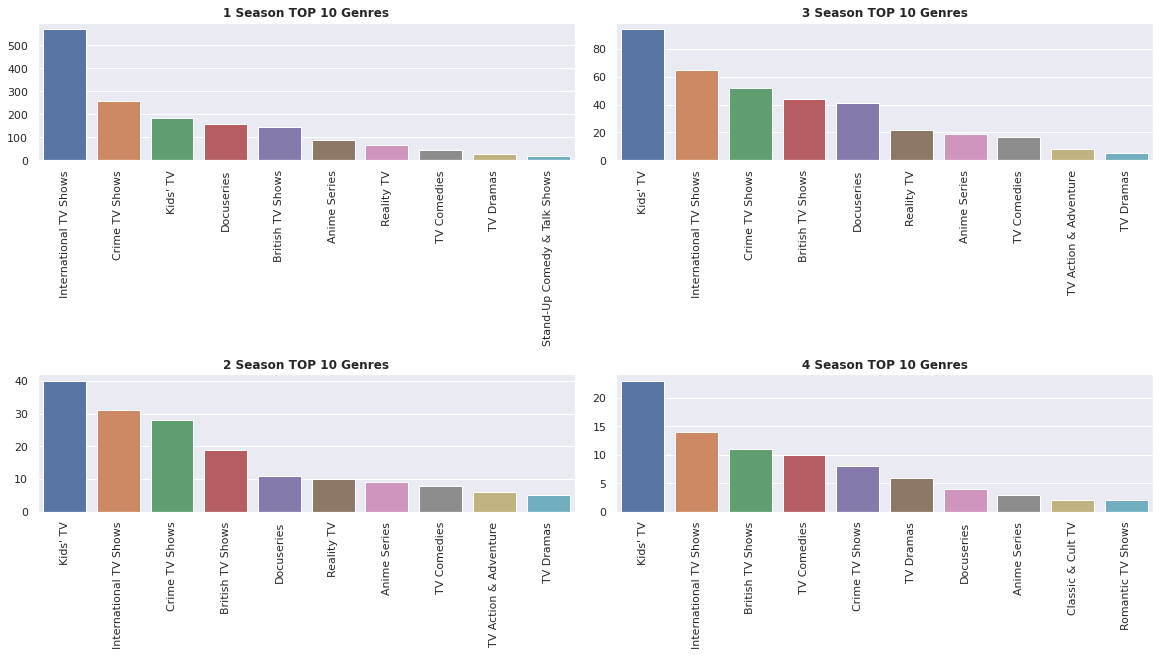

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(16,9), constrained_layout = True)

sns.barplot(seasons_top_genres['1 Season'].index, seasons_top_genres['1 Season'].values, ax=axes[0,0])
axes[0,0].set_title('1 Season TOP 10 Genres', fontweight='bold')
axes[0,0].set_xticklabels(seasons_top_genres['1 Season'].index, rotation=90)

sns.barplot(seasons_top_genres['2 Seasons'].index, seasons_top_genres['2 Seasons'].values, ax=axes[0,1])
axes[1,0].set_title('2 Season TOP 10 Genres', fontweight='bold')
axes[1,0].set_xticklabels(seasons_top_genres['2 Seasons'].index, rotation=90)

sns.barplot(seasons_top_genres['3 Seasons'].index, seasons_top_genres['3 Seasons'].values, ax=axes[1,0])
axes[0,1].set_title('3 Season TOP 10 Genres', fontweight='bold')
axes[0,1].set_xticklabels(seasons_top_genres['3 Seasons'].index, rotation=90)

sns.barplot(seasons_top_genres['4 Seasons'].index, seasons_top_genres['4 Seasons'].values, ax=axes[1,1])
axes[1,1].set_title('4 Season TOP 10 Genres', fontweight='bold')
axes[1,1].set_xticklabels(seasons_top_genres['4 Seasons'].index, rotation=90)

In [ ]:
df_netflix.loc[df_netflix['type'] == 'Movie', 'duration'] = df_movie['duration_interval']

##Cast

In [ ]:
df_netflix['cast'] = df_netflix['cast'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

In [ ]:
actor_genre_df = pd.DataFrame({}, columns=['actor', 'genre'])
most_common__movie_actors[0][0]
for actor in most_common__movie_actors:
    for i, record in df_netflix.iterrows():
        if actor[0] in record['cast']:
           actor_genre_df = actor_genre_df.append({'actor': actor[0], 'genre': record['main_genre']}, ignore_index=True)

In [ ]:
top5_actors_genres = {}
for actor in most_common__movie_actors:
    top5_actors_genres.update({actor[0]:actor_genre_df[actor_genre_df['actor'] == actor[0]]['genre'].value_counts()[:5]})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

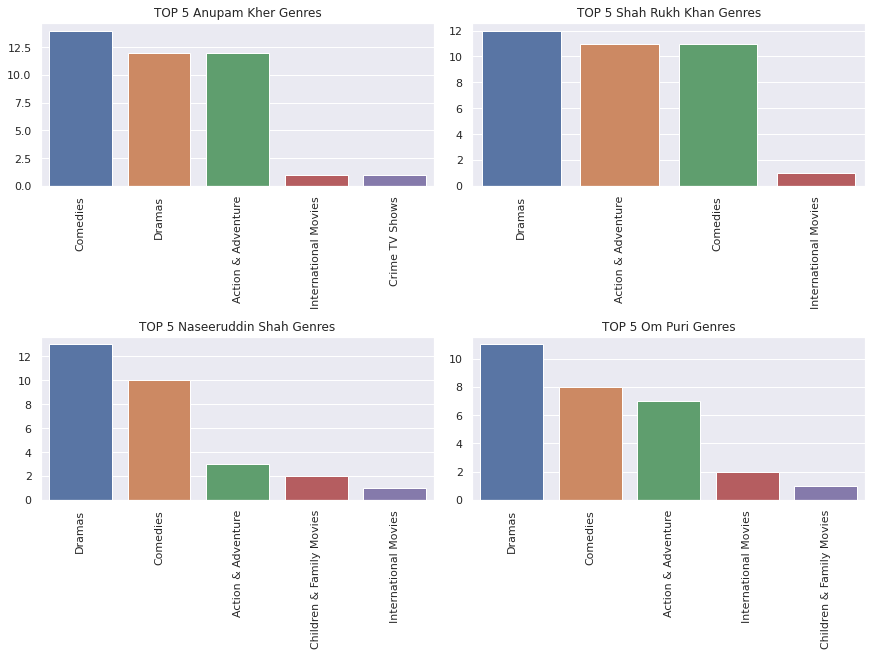

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12, 9), constrained_layout = True)
top5_actors_genres['Anupam Kher']
itter_name = 0
for i in range(2):
    for j in range(2):
        name = list(top5_actors_genres.keys())[itter_name]
        actor_genres = top5_actors_genres[name]
        sns.barplot(actor_genres.index, actor_genres.values, ax=axes[i, j])
        axes[i,j].set_title('TOP 5 ' + name + ' Genres')
        axes[i,j].set_xticklabels(actor_genres.index, rotation=90)
        itter_name += 1


#Pre-clustering

In [ ]:
train_df = df_netflix.copy()
train_df = train_df.drop(['title', 'cast', 'country', 'year_added'], axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Num of unique records')

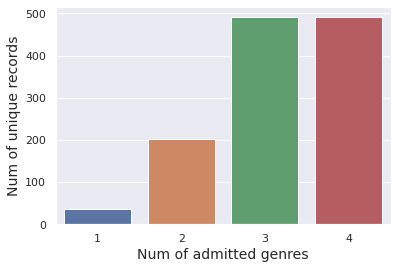

In [ ]:
num_of_genres = []

for i in range(4):
    top_cast = df_netflix['genres'].apply(lambda x: ', '.join(x[:i+1]))
    num_of_genres.append(top_cast.unique().shape[0])
sns.barplot([1, 2, 3, 4], num_of_genres)
plt.xlabel('Num of admitted genres', fontsize=14)
plt.ylabel('Num of unique records', fontsize=14)

In [ ]:
train_df['genres'] = train_df['genres'].apply(lambda x: ', '.join(x))

In [ ]:
train_df = train_df.set_index('show_id')

In [ ]:
train_df.dtypes

type              object
director          object
release_year       int64
duration          object
description       object
main_country      object
age_group       category
genres            object
main_genre        object
dtype: object

In [ ]:
train_df['director'] = train_df['director'].astype('category').cat.codes
train_df['duration'] = train_df['duration'].astype('category').cat.codes
train_df['main_country'] = train_df['main_country'].astype('category').cat.codes
train_df['type'] = train_df['type'].astype('category').cat.codes
train_df['age_group'] = train_df['age_group'].astype('category').cat.codes
train_df['genres'] = train_df['genres'].astype('category').cat.codes
train_df['main_genre'] = train_df['main_genre'].astype('category').cat.codes

In [ ]:
train_df.head()

,type,director,release_year,duration,description,main_country,age_group,genres,main_genre
show_id,,,,,,,,,
s1,1,2716,2020,12,In a future where the elite inhabit an island ...,6,0,397,16
s2,0,1840,2016,2,After a devastating earthquake hits Mexico Cit...,42,0,309,12
s3,0,1289,2011,0,"When an army recruit is found dead, his fellow...",60,0,335,13
s4,0,3446,2009,0,"In a postapocalyptic world, rag-doll robots hi...",75,1,47,0
s5,0,3177,2008,2,A brilliant group of students become card-coun...,75,1,293,12


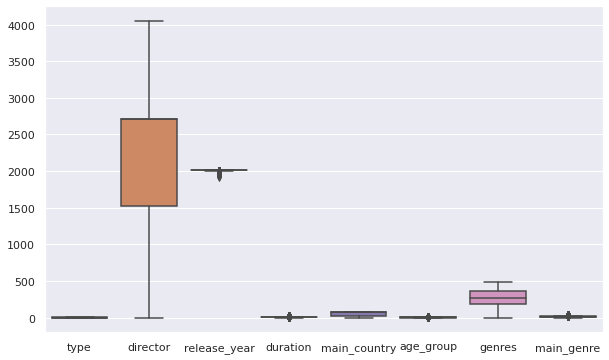

In [ ]:
fig, axes = plt.subplots(figsize=(10,6))
sns.boxplot(data=train_df, ax=axes)

In [ ]:
unscaled_df = train_df.drop('description', axis=1)

(-4000.0, 4000.0)

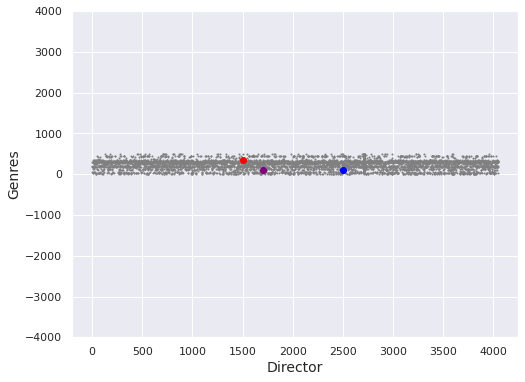

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(unscaled_df['director'], unscaled_df['genres'], s=1, c=['gray'])
plt.scatter([2500], [100], c=['blue'])
plt.scatter([1700], [100], c=['purple'])
plt.scatter([1500], [340], c=['red'])
plt.xlabel('Director', fontsize=14)
plt.ylabel('Genres', fontsize=14)

plt.ylim(bottom=-4000, top=4000)

In [ ]:
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values,
                                     axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return(df_qn)

In [ ]:
scaled_df = quantile_normalize(unscaled_df)

(0.0, 1000.0)

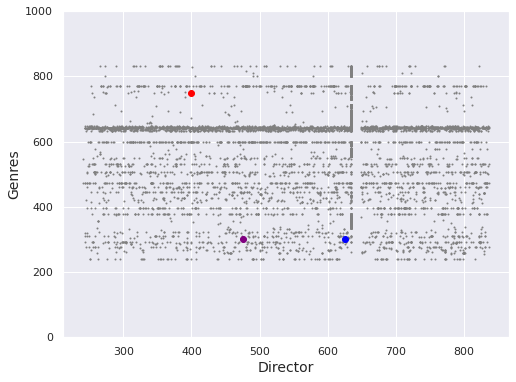

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(scaled_df['director'], scaled_df['genres'], s=1, c=['gray'])
plt.scatter([475], [300], c=['purple'])
plt.scatter([625], [300], c=['blue'])
plt.scatter([400], [750], c=['red'])
plt.xlabel('Director', fontsize=14)
plt.ylabel('Genres', fontsize=14)

plt.ylim(bottom=0, top=1000)

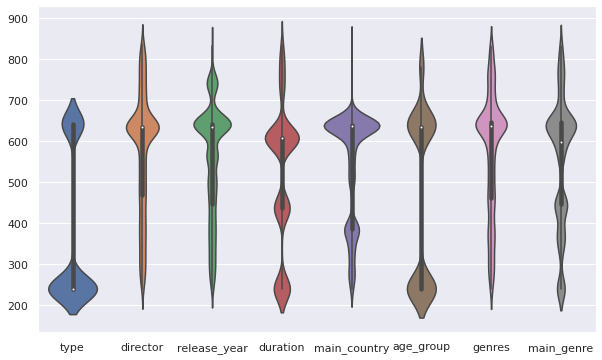

In [ ]:
fig, axes = plt.subplots(figsize=(10,6))
sns.violinplot(data=scaled_df, ax=axes)

In [ ]:
x_embedded = TSNE(n_components=2).fit_transform(scaled_df)
x_embedded.shape

(7777, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


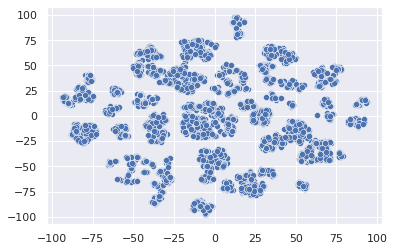

In [ ]:
sns.scatterplot(x_embedded[:,0], x_embedded[:,1])

##First K-means

In [ ]:
kmeans_base_df = scaled_df.copy()

In [ ]:
kmeans_base = KMeans(n_clusters=3).fit(kmeans_base_df)
kmeans_base_df['cluster_id'] = kmeans_base.predict(kmeans_base_df)

In [ ]:
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(kmeans_base_df)
    distortions.append(kmeanModel.inertia_)

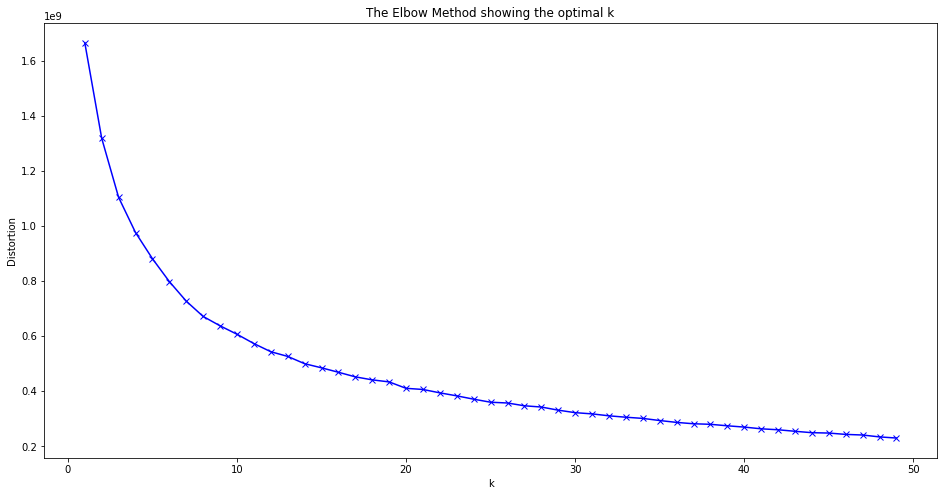

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
sil = []
K = range(2,100)
for k in K:
    kmeans = KMeans(n_clusters = k).fit(kmeans_base_df)
    labels = kmeans.labels_
    sil.append(silhouette_score(kmeans_base_df, labels, metric = 'euclidean'))

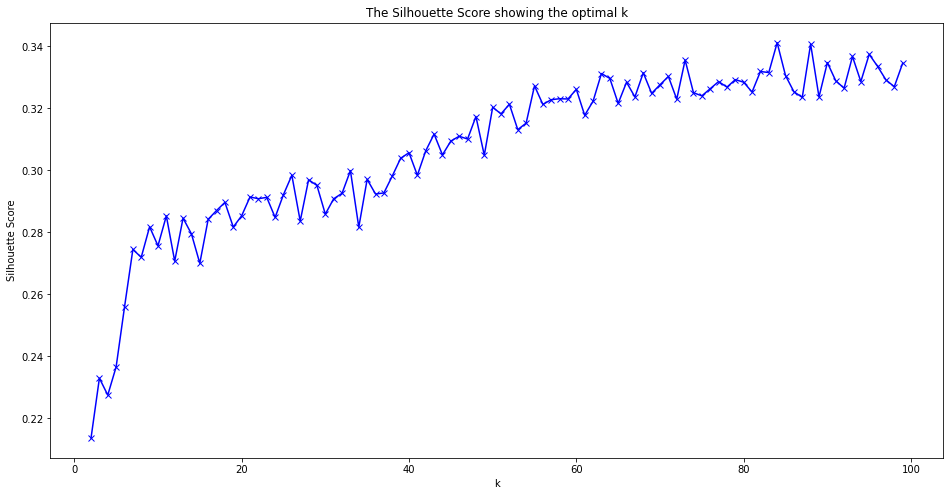

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('The Silhouette Score showing the optimal k')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


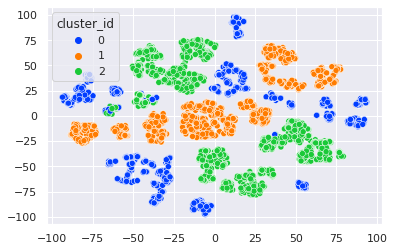

In [ ]:
palette = sns.color_palette("bright", len(set(kmeans_base_df['cluster_id'])))
sns.scatterplot(x_embedded[:,0], x_embedded[:,1], hue=kmeans_base_df['cluster_id'], legend='full', palette=palette)

In [ ]:
dbscan_df = scaled_df.copy()

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(dbscan_df)
distances, indices = nbrs.kneighbors(dbscan_df)

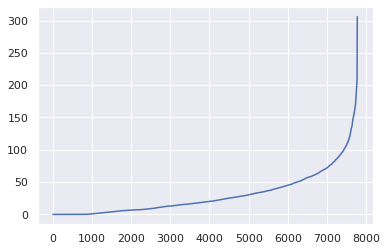

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
dbscan = DBSCAN(eps=125, min_samples=16).fit(dbscan_df)

In [ ]:
dbscan_df['cluster_id'] = dbscan.labels_

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


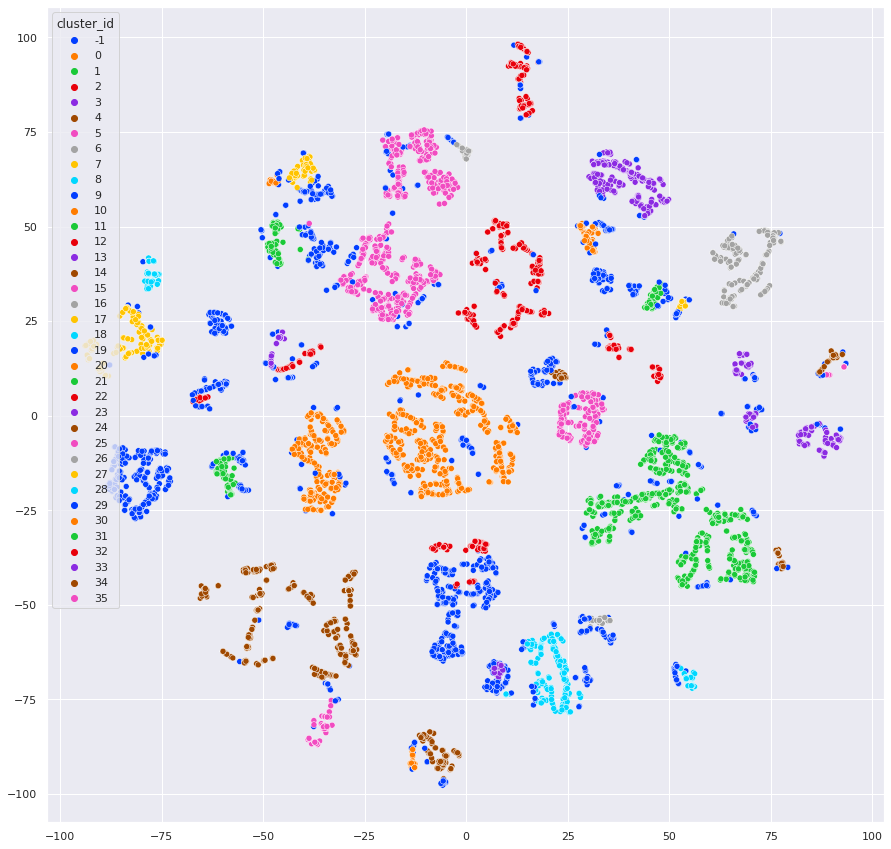

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
palette = sns.color_palette("bright", len(set(dbscan_df['cluster_id'])))
sns.scatterplot(x_embedded[:,0], x_embedded[:,1], hue=dbscan_df['cluster_id'], palette=palette)

## Synposis clustering


In [ ]:
df_token = df_netflix["description"]

maxlen = 1500
training_samples = 800
validation_samples = 450
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_token)
sequences = tokenizer.texts_to_sequences(df_token)

word_index = tokenizer.word_index
print(f"{len(word_index)} unique tokens found")

data = pad_sequences(sequences, maxlen=maxlen)

19068 unique tokens found


In [ ]:
scaler = MinMaxScaler() 
synopsis_scaled = scaler.fit_transform(data)

In [ ]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

In [ ]:
n_clusters = len(dbscan_df['cluster_id'].unique()) - 1
n_epochs   = 8
batch_size = 128

In [ ]:
dims = [synopsis_scaled.shape[-1], 500, 500, 1000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = "rmsprop" #SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size

In [ ]:
dims

[1500, 500, 500, 1000, 10]

In [ ]:
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
autoenc, encoder = autoencoder(dims, init=init)

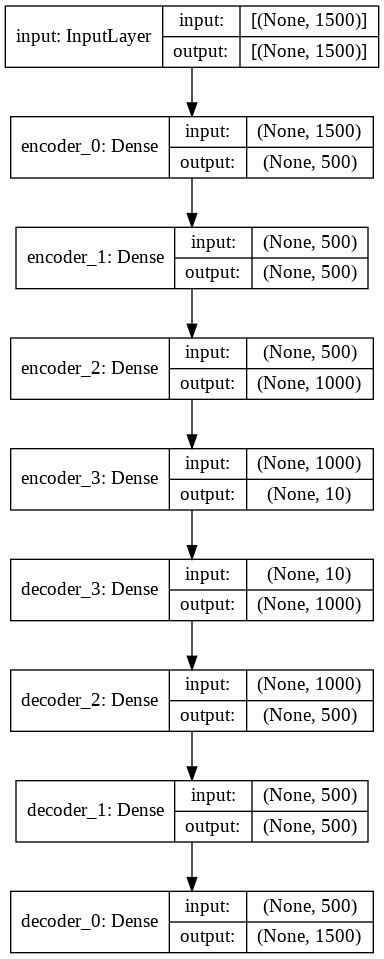

In [ ]:
plot_model(autoenc, to_file='autoencoder.png', show_shapes=True)
Image(filename='autoencoder.png')

In [ ]:
autoenc.compile(optimizer=pretrain_optimizer, loss='binary_crossentropy') 
autoenc.fit(synopsis_scaled, synopsis_scaled, batch_size=batch_size, epochs=pretrain_epochs)

Epoch 1/8
61/61 [==============================] - 7s 91ms/step - loss: 0.0090
Epoch 2/8
61/61 [==============================] - 6s 90ms/step - loss: 0.0076
Epoch 3/8
61/61 [==============================] - 6s 91ms/step - loss: 0.0073
Epoch 4/8
61/61 [==============================] - 5s 89ms/step - loss: 0.0065
Epoch 5/8
61/61 [==============================] - 6s 90ms/step - loss: 0.0059
Epoch 6/8
61/61 [==============================] - 6s 91ms/step - loss: 0.0053
Epoch 7/8
61/61 [==============================] - 5s 89ms/step - loss: 0.0053
Epoch 8/8
61/61 [==============================] - 6s 91ms/step - loss: 0.0052


In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
syn_model = Model(inputs=encoder.input, outputs=clustering_layer)

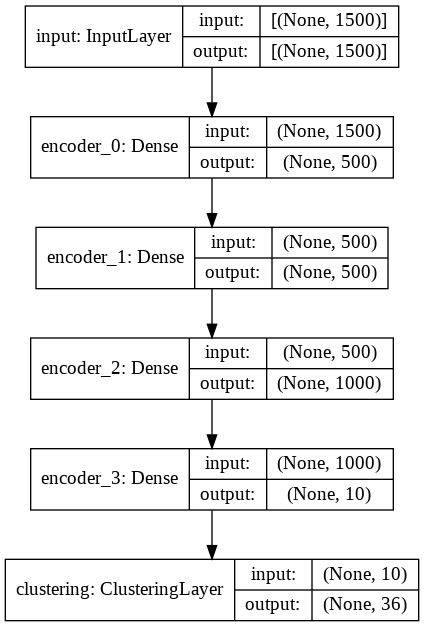

In [ ]:
plot_model(syn_model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

In [ ]:
syn_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [ ]:
kmeans_syn = KMeans(n_clusters=n_clusters, n_init=20)
y_pred_syn = kmeans_syn.fit_predict(encoder.predict(synopsis_scaled))

In [ ]:
y_pred_syn_last = np.copy(y_pred_syn)

In [ ]:
syn_model.get_layer(name='clustering').set_weights([kmeans_syn.cluster_centers_])

In [ ]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
loss = 0
index = 0
maxiter = 1000 # 8000
update_interval = 100 # 140
index_array = np.arange(synopsis_scaled.shape[0])

In [ ]:
tol = 0.001

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = syn_model.predict(synopsis_scaled, verbose=0)
        p = target_distribution(q)

    idx = index_array[index * batch_size: min((index+1) * batch_size, synopsis_scaled.shape[0])]
    loss = syn_model.train_on_batch(x=synopsis_scaled[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= synopsis_scaled.shape[0] else 0

In [ ]:
q = syn_model.predict(synopsis_scaled, verbose=0)
p = target_distribution(q)

y_pred_syn = q.argmax(1)

In [ ]:
unscaled_df['synopsis_cluster_id'] = y_pred_syn

In [ ]:
syn_embedded = TSNE(n_components=2).fit_transform(synopsis_scaled)

syn_embedded.shape

(7777, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


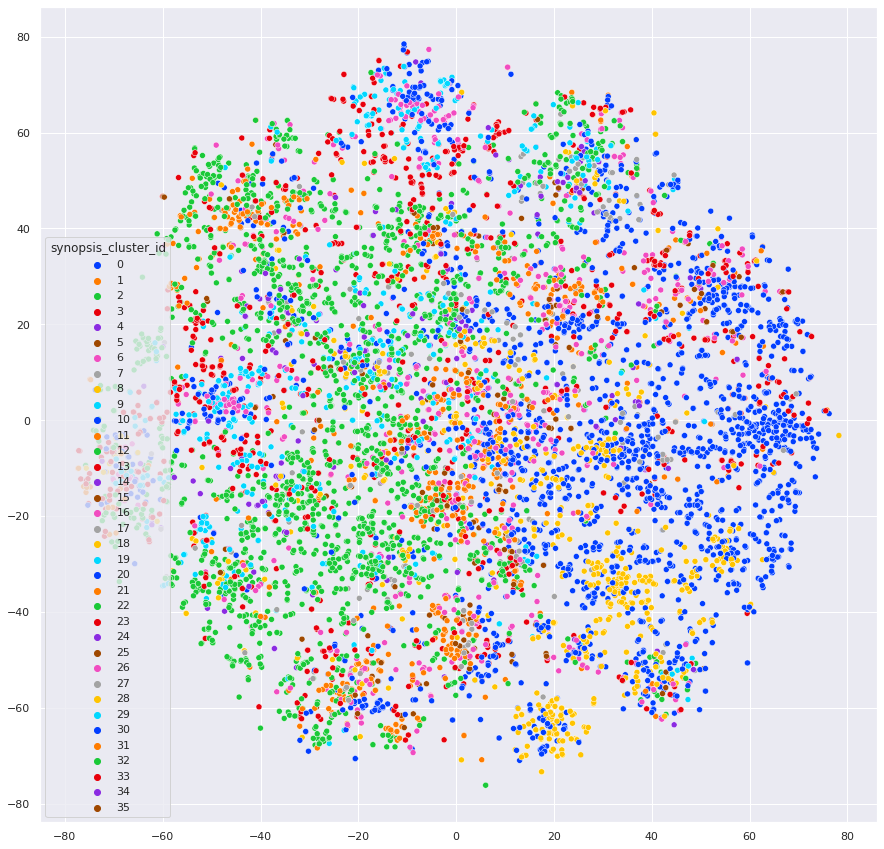

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
palette = sns.color_palette("bright", len(set(unscaled_df['synopsis_cluster_id'])))
sns.scatterplot(syn_embedded[:,0], syn_embedded[:,1], hue=unscaled_df['synopsis_cluster_id'], palette=palette)

In [ ]:
scaled_df = quantile_normalize(unscaled_df)

In [ ]:
scaled_df

,type,director,release_year,duration,main_country,age_group,genres,main_genre,synopsis_cluster_id
show_id,,,,,,,,,
s1,575.333333,566.777778,663.333333,727.222222,241.000000,213.888889,632.444444,580.222222,227.000000
s2,213.888889,457.555556,505.000000,542.888889,484.111111,213.888889,573.222222,571.111111,227.000000
s3,213.888889,389.000000,356.666667,213.888889,524.555556,213.888889,576.888889,576.333333,284.000000
s4,213.888889,669.888889,327.777778,213.888889,572.222222,567.222222,274.888889,213.888889,227.000000
s5,213.888889,636.555556,315.555556,542.888889,572.222222,567.222222,571.111111,571.111111,475.888889
...,...,...,...,...,...,...,...,...,...
s7783,213.888889,458.000000,289.000000,542.888889,563.777778,213.888889,573.222222,571.111111,569.666667
s7784,213.888889,553.222222,453.777778,542.888889,345.222222,567.222222,573.888889,571.111111,438.222222
s7785,213.888889,566.777778,580.444444,213.888889,572.222222,213.888889,567.555556,535.000000,574.444444


## Final Clustering

In [ ]:
spectral_df = scaled_df.copy()

In [ ]:
spectral_model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=16, random_state=0).fit(spectral_df)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [ ]:
spectral_df['cluster_id'] = spectral_model.labels_

In [ ]:
spectral_df

,type,director,release_year,duration,main_country,age_group,genres,main_genre,synopsis_cluster_id,cluster_id
show_id,,,,,,,,,,
s1,575.333333,566.777778,663.333333,727.222222,241.000000,213.888889,632.444444,580.222222,227.000000,28
s2,213.888889,457.555556,505.000000,542.888889,484.111111,213.888889,573.222222,571.111111,227.000000,3
s3,213.888889,389.000000,356.666667,213.888889,524.555556,213.888889,576.888889,576.333333,284.000000,20
s4,213.888889,669.888889,327.777778,213.888889,572.222222,567.222222,274.888889,213.888889,227.000000,4
s5,213.888889,636.555556,315.555556,542.888889,572.222222,567.222222,571.111111,571.111111,475.888889,14
...,...,...,...,...,...,...,...,...,...,...
s7783,213.888889,458.000000,289.000000,542.888889,563.777778,213.888889,573.222222,571.111111,569.666667,3
s7784,213.888889,553.222222,453.777778,542.888889,345.222222,567.222222,573.888889,571.111111,438.222222,1
s7785,213.888889,566.777778,580.444444,213.888889,572.222222,213.888889,567.555556,535.000000,574.444444,20


In [ ]:
x_embedded = TSNE(n_components=2).fit_transform(spectral_df.drop('cluster_id', axis=1))
x_embedded.shape

(7777, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


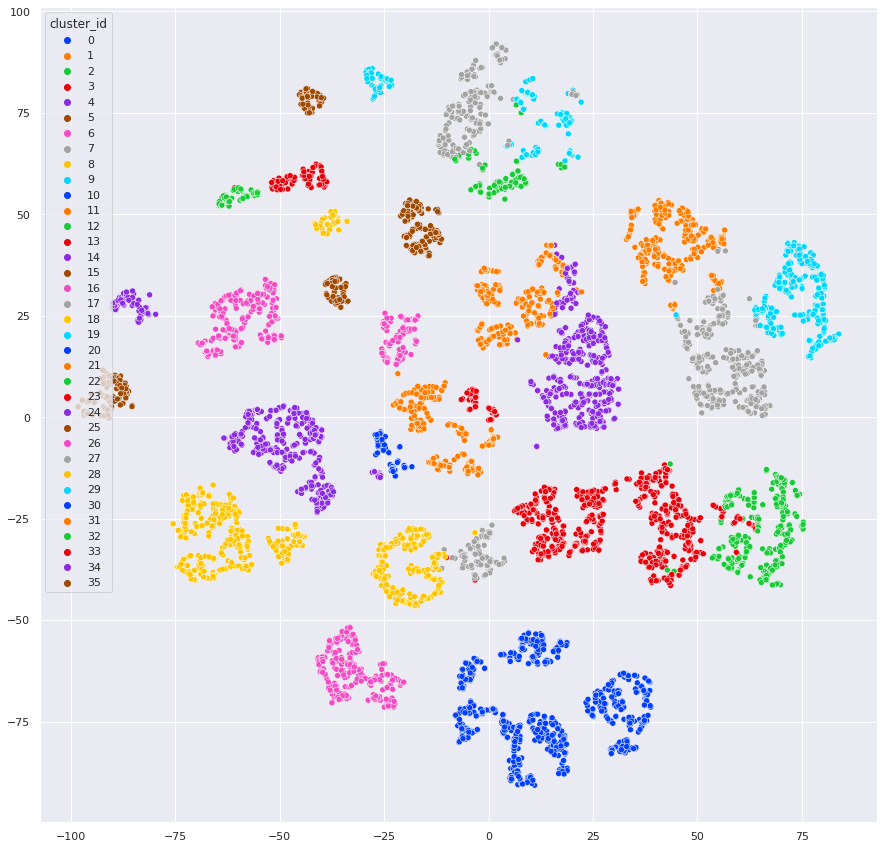

In [ ]:
sns.set(rc={'figure.figsize':(15,15)})
palette = sns.color_palette("bright", len(set(spectral_df['cluster_id'])))
sns.scatterplot(x_embedded[:,0], x_embedded[:,1], hue=spectral_df['cluster_id'], palette=palette)

##Test

In [ ]:
spectral_df = spectral_df.reset_index()
syn_df_netflix = syn_df_netflix.reset_index()

In [ ]:
df_netflix['synopsis_id'] = syn_df_netflix['synopsis_cluster_id']
df_netflix['cluster_id'] = spectral_df['cluster_id']

In [ ]:
df_netflix['synopsis_id'].value_counts()

32.0    2831
17.0    1705
11.0     381
27.0     329
5.0      222
20.0     215
13.0     193
23.0     183
6.0      177
26.0     141
12.0     125
30.0     110
35.0     109
28.0      92
14.0      90
31.0      74
15.0      70
1.0       69
8.0       65
2.0       58
22.0      58
4.0       56
0.0       56
24.0      50
29.0      46
18.0      45
21.0      43
9.0       43
33.0      37
25.0      23
3.0       19
34.0      15
16.0      14
7.0        9
19.0       8
10.0       6
Name: synopsis_id, dtype: int64

In [ ]:
def top_5_related(df, movie_name):
    cluster_of = df[df['title'] == movie_name]['cluster_id'].values[0]
    synopsis_id = df[df['title'] == movie_name]['synopsis_id'].values[0]
    main_genre = df[df['title'] == movie_name]['main_genre'].values[0]
    same_cluster = df[df['cluster_id'] == cluster_of]
    same_synopsis = same_cluster[same_cluster['synopsis_id'] == synopsis_id]
    same_main_genre = same_synopsis[same_synopsis['main_genre'] == main_genre]
    same_main_genre = same_main_genre.sort_values('genres')
    same_main_genre = same_main_genre[same_main_genre['title'] != movie_name]
    return same_main_genre.head(5)

In [ ]:
df_netflix[df_netflix['title'] == '21']['description'][4]

'A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack.'

In [ ]:
top_5_related(df_netflix, '21')['description'][4854]

'A heartbreaking home birth leaves a woman grappling with the profound emotional fallout, isolated from her partner and family by a chasm of grief.'